In [1]:
import numpy as np
import pandas as pd

import sklearn.metrics as mtr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, merge, Add
from keras.layers.embeddings import Embedding

from sklearn.model_selection import KFold,GroupKFold

import warnings
import random as rn
import math
import datetime
import tensorflow as tf
from keras.models import load_model
import os
import tqdm

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 200

#from kaggle.competitions import nflrush
#env = nflrush.make_env()
#iter_test = env.iter_test()

Using TensorFlow backend.


In [2]:
# evaluation metric
def crps(y_true, y_pred):
    y_true = np.clip(np.cumsum(y_true, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    return ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true.shape[0]) 


# author : nlgn
# Link : https://www.kaggle.com/kingychiu/keras-nn-starter-crps-early-stopping
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_train, y_train = self.data[0][0], self.data[0][1]
        y_pred = self.model.predict(X_train)
        y_true = np.clip(np.cumsum(y_train, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        tr_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_train[-1].shape[0])
        tr_s = np.round(tr_s, 6)
        logs['tr_CRPS'] = tr_s

        X_valid, y_valid = self.data[1][0], self.data[1][1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid[-1].shape[0])
        val_s = np.round(val_s, 6)
        logs['val_CRPS'] = val_s
        print('tr CRPS', tr_s, 'val CRPS', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [7]:
def create_features(df):
    
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2
        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def map_team_name(df):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in df['PossessionTeam'].unique():
            map_abbr[abb] = abb
        df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
        df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
        df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)
        df['FieldPosition'] = df['FieldPosition'].map(map_abbr)
        return df
    
    def clean_position(df):
        def get_position(pos):
            if pos == 'SAF':
                return 'DB'
            if pos == 'S':
                return 'DB'
            elif pos == 'OG':
                return 'G'
            elif pos == "OT":
                return 'T'
            else:
                return pos
        df['Position'] = df['Position'].apply(get_position)
        return df
            
    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]
        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['RusherDisYardLine'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y',
                             'RusherDisYardLine','back_oriented_down_field','back_moving_down_field']]
        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
        player_distance = player_distance.groupby(['GameId','PlayId','RusherDisYardLine','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','RusherDisYardLine','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']
        return player_distance
def create_features(df):
    
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2
        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def map_team_name(df):
        map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
        for abb in df['PossessionTeam'].unique():
            map_abbr[abb] = abb
        df['PossessionTeam'] = df['PossessionTeam'].map(map_abbr)
        for abb in df['HomeTeamAbbr'].unique():
            map_abbr[abb] = abb
        df['HomeTeamAbbr'] = df['HomeTeamAbbr'].map(map_abbr)
        for abb in df['VisitorTeamAbbr'].unique():
            map_abbr[abb] = abb
        df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].map(map_abbr)
        for abb in df['FieldPosition'].unique():
            map_abbr[abb] = abb
        df['FieldPosition'] = df['FieldPosition'].map(map_abbr)
        return df
    
    def clean_position(df):
        def get_position(pos):
            if pos == 'SAF':
                return 'DB'
            if pos == 'S':
                return 'DB'
            elif pos == 'OG':
                return 'G'
            elif pos == "OT":
                return 'T'
            else:
                return pos
        df['Position'] = df['Position'].apply(get_position)
        return df
            
    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]
        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')
        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['RusherDisYardLine'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y',
                             'RusherDisYardLine','back_oriented_down_field','back_moving_down_field']]
        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
        player_distance = player_distance.groupby(['GameId','PlayId','RusherDisYardLine','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','RusherDisYardLine','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']
        return player_distance
    
    def create_general_position(df):
        def get_general_position(pos):
            if pos == 'SS' or pos == 'FS' or pos == 'CB' or pos == 'DB':
                return 'DB'
            elif pos == 'DE' or pos == 'DT' or pos == 'DL':
                return 'DL'
            elif pos == 'ILB' or pos == 'OLB' or pos == 'MLB' or pos == 'LB':
                return 'LB'
            elif pos == 'WR':
                return 'WR'
            elif pos == 'TE':
                return 'TE'
            elif pos == 'T' or pos == 'G' or pos == 'C' or pos == 'NT' or pos == 'OL':
                return 'OL'
            elif pos == 'QB' or pos == 'RB' or pos == 'FB' or pos == 'HB' or pos == 'TB' or pos == 'WB':
                return 'OB'
            else:
                return 'Other'
        df['GeneralPosition'] = df['Position'].apply(get_general_position)
        return df
    
    def get_team_on_offense(df):
        df['TeamOnOffense'] = "home"
        df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
        df['IsOnOffense'] = df.Team == df.TeamOnOffense 
        return df
    
    def map_offense_defense_team(df):
        df['OffenseTeam'] = df['VisitorTeamAbbr']
        df.loc[df.TeamOnOffense == 'home', 'OffenseTeam'] = df['HomeTeamAbbr']    
        df['DefenseTeam'] = df['VisitorTeamAbbr']
        df.loc[df.TeamOnOffense == 'away', 'DefenseTeam'] = df['HomeTeamAbbr']
        df['IsOffenseAtHome'] = True
        df.loc[df.TeamOnOffense == 'away', 'IsOffenseAtHome'] = False
        return df
    
    def get_is_offense_winning(df):
        df['OffenseScore'] = df['HomeScoreBeforePlay']
        df.loc[df.TeamOnOffense == 'away', 'OffenseScore'] = df['VisitorScoreBeforePlay']
        df['DefenseScore'] = df['VisitorScoreBeforePlay']
        df.loc[df.TeamOnOffense == 'away', 'DefenseScore'] = df['HomeScoreBeforePlay']
        df['OffenseLessDefenseScore'] = df['OffenseScore'] - df['DefenseScore']
        df['OffenseInOwnTerritory'] = False
        df.loc[df.FieldPosition == df.OffenseTeam, 'OffenseInOwnTerritory'] = True
        df.drop(['OffenseScore','DefenseScore'], axis=1, inplace=True)
        return df

    def get_general_pos_counts(df):
        df['NumberOfBacksOnPlay'] = 0
        df['NumberOfOLinemenOnPlay'] = 0
        df['NumberOfWRsOnPlay'] = 0
        df['NumberOfTEsOnPlay'] = 0
        df['NumberOfDBsOnPlay'] = 0
        df['NumberOfDLinemenOnPlay'] = 0 
        df['NumberOfLBsOnPlay'] = 0
        # Pivot to find counts of each general position
        gen_pos_counts = df[['PlayId','GeneralPosition']].pivot_table(index='PlayId', columns='GeneralPosition', 
                                                                      aggfunc=len, fill_value=0)
        gen_pos_counts = gen_pos_counts.rename(columns = 
                              {'DB':'NumberOfDBsOnPlay', 'DL':'NumberOfDLinemenOnPlay', 
                               'LB':'NumberOfLBsOnPlay', 'OB':'NumberOfBacksOnPlay',
                               'OL':'NumberOfOLinemenOnPlay', 'TE':'NumberOfTEsOnPlay',
                               'WR':'NumberOfWRsOnPlay'})
        gen_pos_counts = gen_pos_counts.reset_index(drop=False)
        del gen_pos_counts.columns.name
        gen_pos_counts_cols = gen_pos_counts.columns.values.tolist()
        gen_pos_counts = gen_pos_counts.loc[gen_pos_counts.index.repeat(22)].reset_index(drop=True)
        df.update(gen_pos_counts)
        return df

    def utc2sec(x):
        return int(x.split("-")[2].split(":")[2].split(".")[0])
    def gameclock2secs(x):
        clock = x.split(":")
        return (60 * int(clock[0])) + int(clock[1])        
    
    def str_to_float(txt):
        try:
            return float(txt)
        except:
            return -1

    def get_time_features(df):
        df['TimeBetweenSnapHandoff'] = df['TimeHandoff'].apply(utc2sec) - df['TimeSnap'].apply(utc2sec)
        df['QuarterGameSecs'] = df['GameClock'].apply(gameclock2secs)
        df['TotalGameSecsPlayed'] = (900 - df['QuarterGameSecs']) + ((df['Quarter'] - 1) * 900)
        df['HalfGameSecsLeft'] = df['QuarterGameSecs']
        df.loc[(df['Quarter'].isin([1,3])), 'HalfGameSecsLeft'] = (900 + df['QuarterGameSecs'])
        return(df)
    
    def get_player_age(df):
        def timesnap2day(x):
            days = x.split("-")
            return 365 * int(days[0]) + 30 * int(days[1]) + int(days[2][:2])    
        def birthday2day(x):
            days = x.split("/")
            return 30 * int(days[0]) + int(days[1]) + 365 * int(days[2])        
        df['PlayerAge'] = df['TimeSnap'].apply(timesnap2day) - df['PlayerBirthDate'].apply(birthday2day)
        df.drop('PlayerBirthDate', axis=1, inplace=True)
        return df
        
    def get_player_weights_bmi(df):
        def height2inch(x):
            height = x.split("-")
            return 12 * int(height[0]) + int(height[1])
        df['PlayerHeight'] = df['PlayerHeight'].apply(height2inch)
        df = df.rename(columns={'PlayerWeight':'PlayerMass'})
        df['PlayerBMI'] = df['PlayerMass'] / df['PlayerHeight']
        return df
    def get_is_rusher(df):
        df['IsRusher'] = df.NflId == df.NflIdRusher 
        return df

    def get_redzone(df):
        df['InOffenseRedzone'] = False
        df.loc[df.YardLine <= 30, 'InOffenseRedzone'] = True
        df['InDefenseRedzone'] = False
        df.loc[df.YardLine >= 90, 'InDefenseRedzone'] = True    
        return df
    
    def get_qb_kneel(df):
        df['QBKneel'] = False
        df.loc[
            ((df.Quarter == 2) | (df.Quarter == 4)) &
            (df.GameClock <= '02:00') &
            (df.OffenseLessDefenseScore > 0) &
            (df.NumberOfBacksOnPlay >= 3) &
            (df.NumberOfTEsOnPlay >= 2), 'QBKneel'
        ] = True
        return df

    def get_dis_yardline(df):
        """
        For defender use only
        """
        df['DisYardLine'] = 0
        df.loc[df.IsOnOffense == True, 'DisYardLine'] = df['YardLine'] - df['X']
        df.loc[df.IsOnOffense == False, 'DisYardLine'] = df['X'] - df['YardLine']
        return df
    
    def get_no_defenders_yl(df):
        df['NoDefenderYL'] = 'NaN'
        df.loc[(df.IsOnOffense == False) & (df.DisYardLine < 0), 'NoDefenderYL'] = 'NoDefendersBelow0YL'
        df.loc[(df.IsOnOffense == False) & ((df.DisYardLine >= 0) & (df.DisYardLine < 3)), 'NoDefenderYL'] = 'NoDefenders0_2YL'
        df.loc[(df.IsOnOffense == False) & ((df.DisYardLine >= 3) & (df.DisYardLine < 6)), 'NoDefenderYL'] = 'NoDefenders3_5YL'
        df.loc[(df.IsOnOffense == False) & ((df.DisYardLine >= 6) & (df.DisYardLine < 9)), 'NoDefenderYL'] = 'NoDefenders6_8YL'
        df.loc[(df.IsOnOffense == False) & (df.DisYardLine >= 9), 'NoDefenderYL'] = 'NoDefendersAbove9YL'
        df['NoDefendersBelow0YL'] = 0
        df['NoDefenders0_2YL'] = 0
        df['NoDefenders3_5YL'] = 0
        df['NoDefenders6_8YL'] = 0
        df['NoDefendersAbove9YL'] = 0
        # Pivot to find counts of each general position
        no_defenders = df[['PlayId','NoDefenderYL']].pivot_table(index='PlayId', columns='NoDefenderYL', 
                                                                      aggfunc=len, fill_value=0)
        no_defenders = no_defenders.reset_index(drop=False).drop('NaN', axis=1)
        del no_defenders.columns.name
        no_defenders_cols = no_defenders.columns.values.tolist()
        no_defenders = no_defenders.loc[no_defenders.index.repeat(22)].reset_index(drop=True)
        df.update(no_defenders)
        return df
    
    def get_inside_runs(df):
        # Outside runs
        #df['IsOutsideRun'] = 0
        #outside1 = df[ # Outside seams and running out
        #    (((df.RusherY > -2.00) & (df.RusherY <= 23.55)) & ((df.RusherDir > 90) & (df.RusherDir <= 270))) | 
        #    (((df.RusherY > 29.75) & (df.RusherY <= 55.00)) & ((df.RusherDir > 270) | (df.RusherDir <=  90)))
        #]['PlayId']
        #outside2 = df[ # Inside seams and running out
        #    (((df.RusherY > 23.55) & (df.RusherY <= 29.75)) & ((df.RusherDir > 270) | (df.RusherDir <= 40))) |
        #    (((df.RusherY > 23.55) & (df.RusherY <= 29.75)) & ((df.RusherDir > 140) & (df.RusherDir <= 270)))
        #]['PlayId']
        #outside = outside1.tolist() + outside2.tolist()
        
        # Inside runs
        df['IsInside'] = 0
        inside1 = df[ # Outside seams and running in
            (((df.RusherY > -2.00) & (df.RusherY <= 23.55)) & ((df.RusherDir > 270) | (df.RusherDir <= 90))) |
            (((df.RusherY > 29.75) & (df.RusherY <= 55.00)) & ((df.RusherDir > 90) & (df.RusherDir <= 270)))
        ]['PlayId']
        inside2 = df[ # Inside the seams and running in
            (((df.RusherY > 23.55) & (df.RusherY <= 29.75)) & ((df.RusherDir > 40) & (df.RusherDir <= 140)))
        ]['PlayId']
        inside = inside1.tolist() + inside2.tolist()
        df.loc[df.PlayId.isin(inside), 'IsInside'] = 1
        return df
    
    def get_dis_from_yl(df):
        """
        For both off and def
        """
        df['DisFromYL'] = abs(df['YardLine'] - df['X'])
        return df
    
    def get_dis_rusher(df):
        rusher_xy = df.loc[df.IsRusher == True, ['GameId','PlayId','X','Y']].rename(columns={'X':'RusherX','Y':'RusherY'})
        df = df.merge(rusher_xy, on=['GameId','PlayId'])
        df['DisRusher'] = df[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
        df.drop(['RusherX','RusherY'], axis=1,inplace=True)
        return df

    def get_dis_features(df):
        """
        Returns DisRusherNearestYardLine, RusherDisQB, RusherDisC and RusherDisMLB, DisC, DisQB
        """
        def get_rusher_dis_mlb(df):
            lb_xy = df.loc[(df.Position == 'MLB') | (df.Position == 'ILB'), 
                                   ['PlayId','X','Y']].rename(columns={'X':'MLBX', 'Y':'MLBY'})
            rusher_lb_xy = lb_xy.merge(rusher_xy, on=['PlayId'], how='left')
            rusher_lb_xy['RusherDisMLB'] = rusher_lb_xy[
                ['RusherX','RusherY','MLBX','MLBY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
            rusher_lb_xy.drop(['RusherX','RusherY','MLBX','MLBY'],axis=1, inplace=True)
            rusher_lb_dis = rusher_lb_xy.groupby(['PlayId']).agg({'RusherDisMLB':['min'],}).reset_index()
            rusher_lb_dis.columns = ['PlayId','RusherDisMLB']
            return rusher_lb_dis
        
        rusher_xy = df.loc[df.IsRusher == True, ['PlayId','X','Y']].rename(columns={'X':'RusherX','Y':'RusherY'})
        qb_xy = df.loc[df.Position == 'QB', ['PlayId','X','Y']].rename(columns={'X':'QBX','Y':'QBY'})
        c_xy = df.loc[df.Position == 'C', ['PlayId','X','Y']].rename(columns={'X':'CX','Y':'CY'})
        try:
            rusher_lb_dis = get_rusher_dis_mlb(df)
        except:
            rusher_lb_dis = np.nan
        rusherxy_qbxy = rusher_xy.merge(qb_xy, on=['PlayId'])
        rusherxy_qbxy_cxy = rusherxy_qbxy.merge(c_xy, on=['PlayId'])
        try:
            dis_total_xy = rusherxy_qbxy_cxy.merge(rusher_lb_dis, on=['PlayId'])
        except:
            dis_total_xy = rusherxy_qbxy_cxy
            dis_total_xy['RusherDisMLB'] = np.nan
        dis_total_xy = dis_total_xy.loc[dis_total_xy.index.repeat(22)].reset_index(drop=True)
        dis_total_xy.drop(['PlayId'], axis=1, inplace=True)
        df['RusherX'] = 0
        df['RusherY'] = 0
        df['QBX'] = 0
        df['QBY'] = 0
        df['CX'] = 0
        df['CY'] = 0
        df['RusherDisMLB'] = 0
        df.update(dis_total_xy) 

        df['DisRusherNearestYardLine'] = df[['YardLine','RusherY','X','Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)    
        df['RusherDisQB'] = df[['RusherX','RusherY','QBX','QBY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)    
        df['RusherDisC'] = df[['RusherX','RusherY','CX','CY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)
        df['DisC'] = df[['X','Y','CX','CY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)    
        df['DisQB'] = df[['X','Y','QBX','QBY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)    

        df.drop(['RusherX','RusherY','QBX','QBY','CX','CY'], axis=1,inplace=True)
        return df 

    
    def get_team_aggs(df, col, for_offense=True):
        aggs = ['Avg','Min','Max','Std']
        if for_offense == True:
            team_agg = df[df.IsOnOffense == True][['PlayId'] + [col]]
            team_agg = df[['PlayId'] + [col]]
            team_agg = team_agg.groupby(['PlayId']).agg({col:['mean','min','max','std']}).reset_index()
            avg_col = 'AvgOffense' + col
            min_col = 'MinOffense' + col
            max_col = 'MaxOffense' + col
            std_col = 'StdOffense' + col
        if for_offense == False:
            team_agg = df[df.IsOnOffense == False][['PlayId'] + [col]]
            team_agg = team_agg.groupby(['PlayId']).agg({col:['mean','min','max','std']}).reset_index()
            avg_col = 'AvgDefense' + col
            min_col = 'MinDefense' + col
            max_col = 'MaxDefense' + col
            std_col = 'StdDefense' + col
                
        team_agg.drop(['PlayId'], axis=1, inplace=True)
        team_agg_cols = [avg_col,min_col,max_col,std_col]
        team_agg.columns = team_agg_cols
        team_agg = team_agg.loc[team_agg.index.repeat(22)].reset_index(drop=True)
        for col in team_agg_cols:
            df[col] = 0
        df.update(team_agg)
        #print(len(team_agg))
        return df
    
    def get_rusher_dis_mlb_inside(df):
        try:
            df['RusherDisMLBByIsInside'] = (1 / df['RusherDisMLB']) * df['IsInside']
            df['RusherDisMLBByIsInside'] = df['RusherDisMLBByIsInside'].replace([np.inf, -np.inf], np.nan)
            return df
        except:
            df['RusherDisMLBByIsInside'] = np.nan
            return df
        
    def get_yards_by_down(df):
        df['YardsByDownSqrt'] = (df['Distance'] * df['Down']) **(1/2)
        return df
    
    def get_diff_rusher_dir_otation(df):
        df['DiffRusherDirOtation'] = df['RusherDir'] - df['RusherOrientation']
        return df
    
    def get_mech_feats(df):
        df['Weight'] = df['PlayerMass'] * 9.806 # acceleration gravity
        df['ChangeTime'] = df['Dis'] / df['S']
        df['Force'] = df['PlayerMass'] * df['A']
        df['Momentum'] = df['PlayerMass'] * df['S']
        df['KE'] = 0.5 * df['PlayerMass'] * (df['S']**2)
        df['Work'] = df['Force'] * df['Dis']
        df['Power'] = df['Work'] / df['ChangeTime']
        df['Impulse'] = df['Force'] * df['ChangeTime']
        angle = 90 - df['Dir']
        df['SX'] = np.abs(df['S'] * np.cos(angle))
        df['SY'] = np.abs(df['S'] * np.sin(angle))    
        df['ForceX'] = np.abs(df['Force'] * np.cos(angle))
        df['ForceY'] = np.abs(df['Force'] * np.sin(angle))
        df['MomentumX'] = np.abs(df['Momentum'] * np.cos(angle))
        df['MomentumY'] = np.abs(df['Momentum'] * np.sin(angle))
        df['WorkX'] = np.abs(df['Work'] * np.cos(angle))
        df['WorkY'] = np.abs(df['Work'] * np.sin(angle))
        df['PowerX'] = np.abs(df['Power'] * np.cos(angle))
        df['PowerY'] = np.abs(df['Power'] * np.sin(angle))
        df['ImpulseX'] = np.abs(df['Impulse'] * np.cos(angle))
        df['ImpulseY'] = np.abs(df['Impulse'] * np.sin(angle)) 
        return df
    
    def get_gen_position_feats(df, position): 
        pos_feat = df.loc[df.GeneralPosition == position, ['PlayId','A','S','Dir',
                                                    'Orientation','Dis',
                                                    'PlayerMass','PlayerHeight']]
        pos_feat = pos_feat.rename(columns={'A':position+'A','S':position+'S','Dir':position+'Dir',
                                            'Orientation':position+'Orientation',
                                            'Dis':position+'Dis','PlayerMass':position+'Weight',
                                            'PlayerHeight':position+'Height'})
        pos_feat = pos_feat.groupby(['PlayId']).agg(
            {position+'A':['mean','min','max'], 
             position+'S':['mean','min','max'], 
             position+'Dir':['mean','min','max'], 
             position+'Orientation':['mean','min','max'], 
             position+'Dis':['mean','min','max'], 
             position+'Weight':['mean','min','max'], 
             position+'Height':['mean','min','max']}).reset_index()
        pos_feat.columns = [''.join(col) for col in pos_feat.columns.values]
        pos_feat_columns = pos_feat.columns.tolist()
        pos_feat_columns.remove('PlayId')
        pos_feat.drop('PlayId',axis=1,inplace=True)
        pos_feat = pos_feat.loc[pos_feat.index.repeat(22)].reset_index(drop=True)
        for feat in pos_feat_columns:
            df[feat] = 0
        df.update(pos_feat)
        return df

    def get_off_less_def_feats(df, feat):
        off_feat = df.loc[df.IsOnOffense == True, ['PlayId',feat]]
        off_feat = off_feat.groupby(['PlayId']).agg({feat:['sum']}).reset_index()
        off_feat.drop('PlayId', axis=1,inplace=True)
        off_feat.columns = ['Off'+feat]
        def_feat = df.loc[df.IsOnOffense == False, ['PlayId',feat]]
        def_feat = def_feat.groupby(['PlayId']).agg({feat:['sum']}).reset_index()
        def_feat.drop('PlayId', axis=1,inplace=True)
        def_feat.columns = ['Def'+feat]
        off_def_feat = pd.DataFrame(off_feat['Off'+feat] - def_feat['Def'+feat], columns=['OffLessDef'+feat])

        df['OffLessDef'+feat] = 0
        off_def_feat = off_def_feat.loc[off_def_feat.index.repeat(22)].reset_index(drop=True)
        df.update(off_def_feat)
        #df.drop(feat, axis=1,inplace=True)
        return df
    
    def get_rusher_feats(df):
        rusher_feats = df.loc[df.IsRusher == True,['X','Y','S','A','Dis',
                                                   'Orientation','Dir','DisFromYL',
                                                   'PlayerMass','PlayerHeight']]
        rusher_feats = rusher_feats.loc[rusher_feats.index.repeat(22)].reset_index(drop=True)
        df.update(rusher_feats)
        df = df.rename(columns={'X':'RusherX','Y':'RusherY','S':'RusherS',
                                'A':'RusherA','Dis':'RusherDis',
                                'Orientation':'RusherOrientation',
                                'Dir':'RusherDir','DisFromYL':'RusherDisYL',
                                'PlayerMass':'RusherMass',
                                'PlayerHeight':'RusherHeight'})
        df['RusherWeight'] = df['RusherMass'] * 9.806 # acceleration gravity
        df['ChangeTime'] = df['RusherDis'] / df['RusherS']
        df['RusherForce'] = df['RusherMass'] * df['RusherA']
        df['RusherMomentum'] = df['RusherMass'] * df['RusherS']
        df['RusherKE'] = 0.5 * df['RusherMass'] * (df['RusherS']**2)
        df['RusherWork'] = df['RusherForce'] * df['RusherDis']
        df['RusherPower'] = df['RusherWork'] / df['ChangeTime']
        df['RusherImpulse'] = df['RusherForce'] * df['ChangeTime']
        angle = 90 - df['RusherDir']
        df['RusherSX'] = np.abs(df['RusherS'] * np.cos(angle))
        df['RusherSY'] = np.abs(df['RusherS'] * np.sin(angle))    
        df['RusherForceX'] = np.abs(df['RusherForce'] * np.cos(angle))
        df['RusherForceY'] = np.abs(df['RusherForce'] * np.sin(angle))
        df['RusherMomentumX'] = np.abs(df['RusherMomentum'] * np.cos(angle))
        df['RusherMomentumY'] = np.abs(df['RusherMomentum'] * np.sin(angle))
        df['RusherWorkX'] = np.abs(df['RusherWork'] * np.cos(angle))
        df['RusherWorkY'] = np.abs(df['RusherWork'] * np.sin(angle))
        df['RusherPowerX'] = np.abs(df['RusherPower'] * np.cos(angle))
        df['RusherPowerY'] = np.abs(df['RusherPower'] * np.sin(angle))
        df['RusherImpulseX'] = np.abs(df['RusherImpulse'] * np.cos(angle))
        df['RusherImpulseY'] = np.abs(df['RusherImpulse'] * np.sin(angle))
        df['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(df.RusherX.values) - np.square(df.RusherY.values))))
        df['fe5'] = np.square(df['RusherS'].values) + 2 * df['RusherA'].values * df['RusherDis'].values  # N
        df['fe8'] = df['RusherS'].values / np.clip(df['fe1'].values, 0.6, None)
        df.drop(['ChangeTime'],axis=1,inplace=True)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(0)
        return df
    
    def combine_features(df): 
        df = map_team_name(df)
        df = get_team_on_offense(df)
        df = map_offense_defense_team(df)
        df = clean_position(df)
        df = get_is_rusher(df)
        df = get_is_offense_winning(df)
        df = create_general_position(df)
        df = get_general_pos_counts(df)
        df = get_time_features(df)
        df = get_player_age(df)
        df = get_player_weights_bmi(df)
        yardline = update_yardline(df)
        df = update_orientation(df, yardline)         
        df = get_redzone(df)
        #df = get_qb_kneel(df)
        df = get_dis_yardline(df) # use for defender distance only
        df = get_no_defenders_yl(df)
        df = get_dis_from_yl(df) # absolute distance for both off and def
        df = get_dis_rusher(df)
        df = get_dis_features(df)
        df = get_mech_feats(df)
        agg_cols = ['X','Y','A','Dir','DisFromYL','DisRusher','Force','Momentum','ForceX','Dis',
                   #'Orientation','DisRusherNearestYardLine',
                   #'MomentumX',
                    #'S','PlayerBMI','DisC','DisQB','KE','Work',
                    #'Power','Impulse','SX','WorkX','PowerX','ImpulseX'
                   ]
            
        for agg_col in agg_cols:
            df = get_team_aggs(df, col=agg_col, for_offense=True)
            df = get_team_aggs(df, col=agg_col, for_offense=False)
        del agg_cols
        df.drop([#'MinOffenseDisC', 'MinOffenseDisQB',
            'DisQB','DisC','MinOffenseDisRusher'
        ],axis=1,inplace=True)
        df = get_gen_position_feats(df, position='OL')
        df = get_gen_position_feats(df, position='DL')
        df = get_gen_position_feats(df, position='LB')
        off_less_def_feats = ['X'#,'Y','A','Momentum','Force','ForceX','ForceY','MomentumX','MomentumY',
                             #'SX','SY','Weight','Impulse','KE','Work','Power','WorkX','WorkY','PowerX','PowerY','ImpulseX','ImpulseY'
                             ]
        
        for feat in off_less_def_feats:
            df = get_off_less_def_feats(df, feat)
        df = get_rusher_feats(df)
        #df = get_inside_runs(df)
        #df = get_rusher_dis_mlb_inside(df)
        df = get_yards_by_down(df)
        df = get_diff_rusher_dir_otation(df)
        return df
    
    df = combine_features(df)
    df = df.fillna(-999)
    df = df.select_dtypes(exclude=['object'])
    df.drop(['RusherMass','PlayerAge','PlayerBMI','DisYardLine',
             'DisRusher','NflIdRusher','IsOnOffense',
             'NflId','JerseyNumber','IsRusher','DisRusherNearestYardLine',
             'Weight','Force','Momentum','KE','Work','Power','Impulse',
             'SX','SY','ForceX','ForceY','MomentumX','MomentumY','WorkX',
             'WorkY','PowerX','PowerY','ImpulseX','ImpulseY'], axis=1, inplace=True)

    #df = df.drop_duplicates().reset_index(drop=True)
    return df

In [8]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv').head(22)
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

train_basetable = create_features(train)

X = train_basetable.copy()
yards = X.Yards

y = np.zeros((yards.shape[0], 199))
for idx, target in enumerate(list(yards)):
    y[idx][99 + target] = 1
print(train_basetable.shape)
train_basetable.head()

(22, 215)


,GameId,PlayId,RusherX,RusherY,RusherS,RusherA,RusherDis,RusherOrientation,RusherDir,Season,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,DefendersInTheBox,Yards,RusherHeight,Week,Temperature,Humidity,WindSpeed,IsOffenseAtHome,OffenseLessDefenseScore,OffenseInOwnTerritory,NumberOfBacksOnPlay,NumberOfOLinemenOnPlay,NumberOfWRsOnPlay,NumberOfTEsOnPlay,NumberOfDBsOnPlay,NumberOfDLinemenOnPlay,NumberOfLBsOnPlay,TimeBetweenSnapHandoff,QuarterGameSecs,TotalGameSecsPlayed,HalfGameSecsLeft,YardLine,InOffenseRedzone,InDefenseRedzone,NoDefendersBelow0YL,NoDefenders0_2YL,NoDefenders3_5YL,NoDefenders6_8YL,NoDefendersAbove9YL,RusherDisYL,RusherDisMLB,RusherDisQB,RusherDisC,AvgOffenseX,MinOffenseX,MaxOffenseX,StdOffenseX,AvgDefenseX,MinDefenseX,MaxDefenseX,StdDefenseX,AvgOffenseY,MinOffenseY,MaxOffenseY,StdOffenseY,AvgDefenseY,MinDefenseY,MaxDefenseY,StdDefenseY,AvgOffenseA,MinOffenseA,MaxOffenseA,StdOffenseA,AvgDefenseA,MinDefenseA,MaxDefenseA,StdDefenseA,AvgOffenseDir,MinOffenseDir,MaxOffenseDir,StdOffenseDir,AvgDefenseDir,MinDefenseDir,MaxDefenseDir,StdDefenseDir,AvgOffenseDisFromYL,MinOffenseDisFromYL,MaxOffenseDisFromYL,StdOffenseDisFromYL,AvgDefenseDisFromYL,MinDefenseDisFromYL,MaxDefenseDisFromYL,StdDefenseDisFromYL,AvgOffenseDisRusher,MaxOffenseDisRusher,StdOffenseDisRusher,AvgDefenseDisRusher,MinDefenseDisRusher,MaxDefenseDisRusher,StdDefenseDisRusher,AvgOffenseForce,MinOffenseForce,MaxOffenseForce,StdOffenseForce,AvgDefenseForce,...,AvgDefenseForceX,MinDefenseForceX,MaxDefenseForceX,StdDefenseForceX,AvgOffenseDis,MinOffenseDis,MaxOffenseDis,StdOffenseDis,AvgDefenseDis,MinDefenseDis,MaxDefenseDis,StdDefenseDis,OLAmean,OLAmin,OLAmax,OLSmean,OLSmin,OLSmax,OLDirmean,OLDirmin,OLDirmax,OLOrientationmean,OLOrientationmin,OLOrientationmax,OLDismean,OLDismin,OLDismax,OLWeightmean,OLWeightmin,OLWeightmax,OLHeightmean,OLHeightmin,OLHeightmax,DLAmean,DLAmin,DLAmax,DLSmean,DLSmin,DLSmax,DLDirmean,DLDirmin,DLDirmax,DLOrientationmean,DLOrientationmin,DLOrientationmax,DLDismean,DLDismin,DLDismax,DLWeightmean,DLWeightmin,DLWeightmax,DLHeightmean,DLHeightmin,DLHeightmax,LBAmean,LBAmin,LBAmax,LBSmean,LBSmin,LBSmax,LBDirmean,LBDirmin,LBDirmax,LBOrientationmean,LBOrientationmin,LBOrientationmax,LBDismean,LBDismin,LBDismax,LBWeightmean,LBWeightmin,LBWeightmax,LBHeightmean,LBHeightmin,LBHeightmax,OffLessDefX,RusherWeight,RusherForce,RusherMomentum,RusherKE,RusherWork,RusherPower,RusherImpulse,RusherSX,RusherSY,RusherForceX,RusherForceY,RusherMomentumX,RusherMomentumY,RusherWorkX,RusherWorkY,RusherPowerX,RusherPowerY,RusherImpulseX,RusherImpulseY,fe1,fe5,fe8,YardsByDownSqrt,DiffRusherDirOtation
0,2017090700,20170907000118,41.25,30.53,3.63,3.35,0.38,198.02,114.26,2017,1,3,2,0,0,6.0,8,70,1,63.0,77.0,8.0,True,0,True,2,5,3,1,6,4,1,1,854,46,1754,45.0,False,False,1,7,2,0,1,3.75,7.820038,1.449724,4.401931,46.118182,40.24,63.37,4.392297,48.179091,44.94,63.37,5.294079,28.713182,16.64,38.83,6.308114,28.890909,16.64,38.83,7.014714,1.191818,0.32,3.35,0.691807,1.025455,0.32,2.43,0.631338,152.131818,37.41,304.69,69.10972,173.046364,37.41,304.69,81.429631,2.226364,0.06,18.37,3.925483,3.19,0.06,18.37,5.286855,7.680806,22.415872,5.056308,9.752491,4.59331,22.415872,5.327299,286.34,80.64,686.75,153.918266,233.012727,...,119.980292,34.14441,224.056325,68.04185,0.245,0.0,0.59,0.184462,0.184545,0.01,0.51,0.17201,1.182,0.69,1.55,1.488,1.0,1.86,122.73,92.68,161.45,172.994,141.51,226.99,0.228,0.17,0.32,315.6,300,335,76.8,73,81,0.7475,0.32,1.35,0.8425,0.42,1.22,167.355,85.86,264.99,189.615,17.42,356.99,0.1275,0.01,0.31,279.5,252,308,75.5,74,78,0.54,0.54,0.54,0.42,0.42,0.42,254.36,254.36,254.36,0.23,0.23,0.23,0.02,0.02,0.02,245,245,245,75,75,75,-45.34,2010.23,686.75,744.15,1350.63225,260.965,2492.9025,71.891185,2.333106,2.78092,441.39409,526.114835,478.286731,570.088612,167.729754,199.923637,1602.260548,1909.79685,46.206544,55.075382,27.739531,15.7229,0.13086,2.44949,-83.76
1,2017090700,20170907000118,41.25,30.53,3.63,3.35,0.38,198.02,114.26,2017,1,3,2,0,0,6.0,8

In [13]:
df = train

# euclidean distance between rusher and player

# RusherDir = 0:
    # If X=RusherX & Y>RusherY: 0
    # If X=RusherX & Y<RusherY: 180
    # If Y=RusherY & X>RusherX: 90
    # If Y=RusherY & X<RusherX: 270
# Rusher


df

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,TeamOnOffense,IsOnOffense,OffenseTeam,DefenseTeam,IsOffenseAtHome,IsRusher,OffenseLessDefenseScore,OffenseInOwnTerritory,GeneralPosition,NumberOfBacksOnPlay,NumberOfOLinemenOnPlay,NumberOfWRsOnPlay,NumberOfTEsOnPlay,NumberOfDBsOnPlay,NumberOfDLinemenOnPlay,NumberOfLBsOnPlay,TimeBetweenSnapHandoff,QuarterGameSecs,TotalGameSecsPlayed,HalfGameSecsLeft,PlayerAge
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,212,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DB,2,5,3,1,6,4,1,1,854,46,1754,10474
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,288,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DL,2,5,3,1,6,4,1,1,854,46,1754,10383
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,270,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DL,2,5,3,1,6,4,1,1,854,46,1754,10447
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,75,245,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,LB,2,5,3,1,6,4,1,1,854,46,1754,12701
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,72,206,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DB,2,5,3,1,6,4,1,1,854,46,1754,10971
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,74,252,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DL,2,5,3,1,6,4,1,1,854,46,1754,9659
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,71,190,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,home,False,NE,KC,True,False,0,True,DB,2,5,3,1,6,4,1,1,854,46,1754,9236
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE

In [8]:
cat = ['InDefenseRedzone'#,'OffenseInOwnTerritory','InOffenseRedzone',
       #'IsOffenseAtHome','QBKneel','IsInside'
      ]

num = list(set(X.columns.values.tolist()) - set(cat)) 
num.remove('GameId')
num.remove('PlayId')
print(len(cat))
print(len(num))

1
28


In [9]:
scaler = StandardScaler()

# For feature selection only
y_select = train_basetable['Yards']
X_select = X.drop(['GameId','PlayId','Yards'], axis=1)

X_select[num] = scaler.fit_transform(X[num])

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Initial LGB parameters are ...
lgbParams = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    "num_iterations": 1000, 
    "learning_rate": 0.05,
    "lambda_l1": 9,
    "lambda_l2": 0.9,
    "num_leaves": 42,
    "feature_fraction": 0.4,
    "bagging_fraction": 0.45,
    "bagging_freq": 7,
    "min_child_samples": 74,
    "random_state": 14
}

[1000]	valid_0's l1: 3.90402


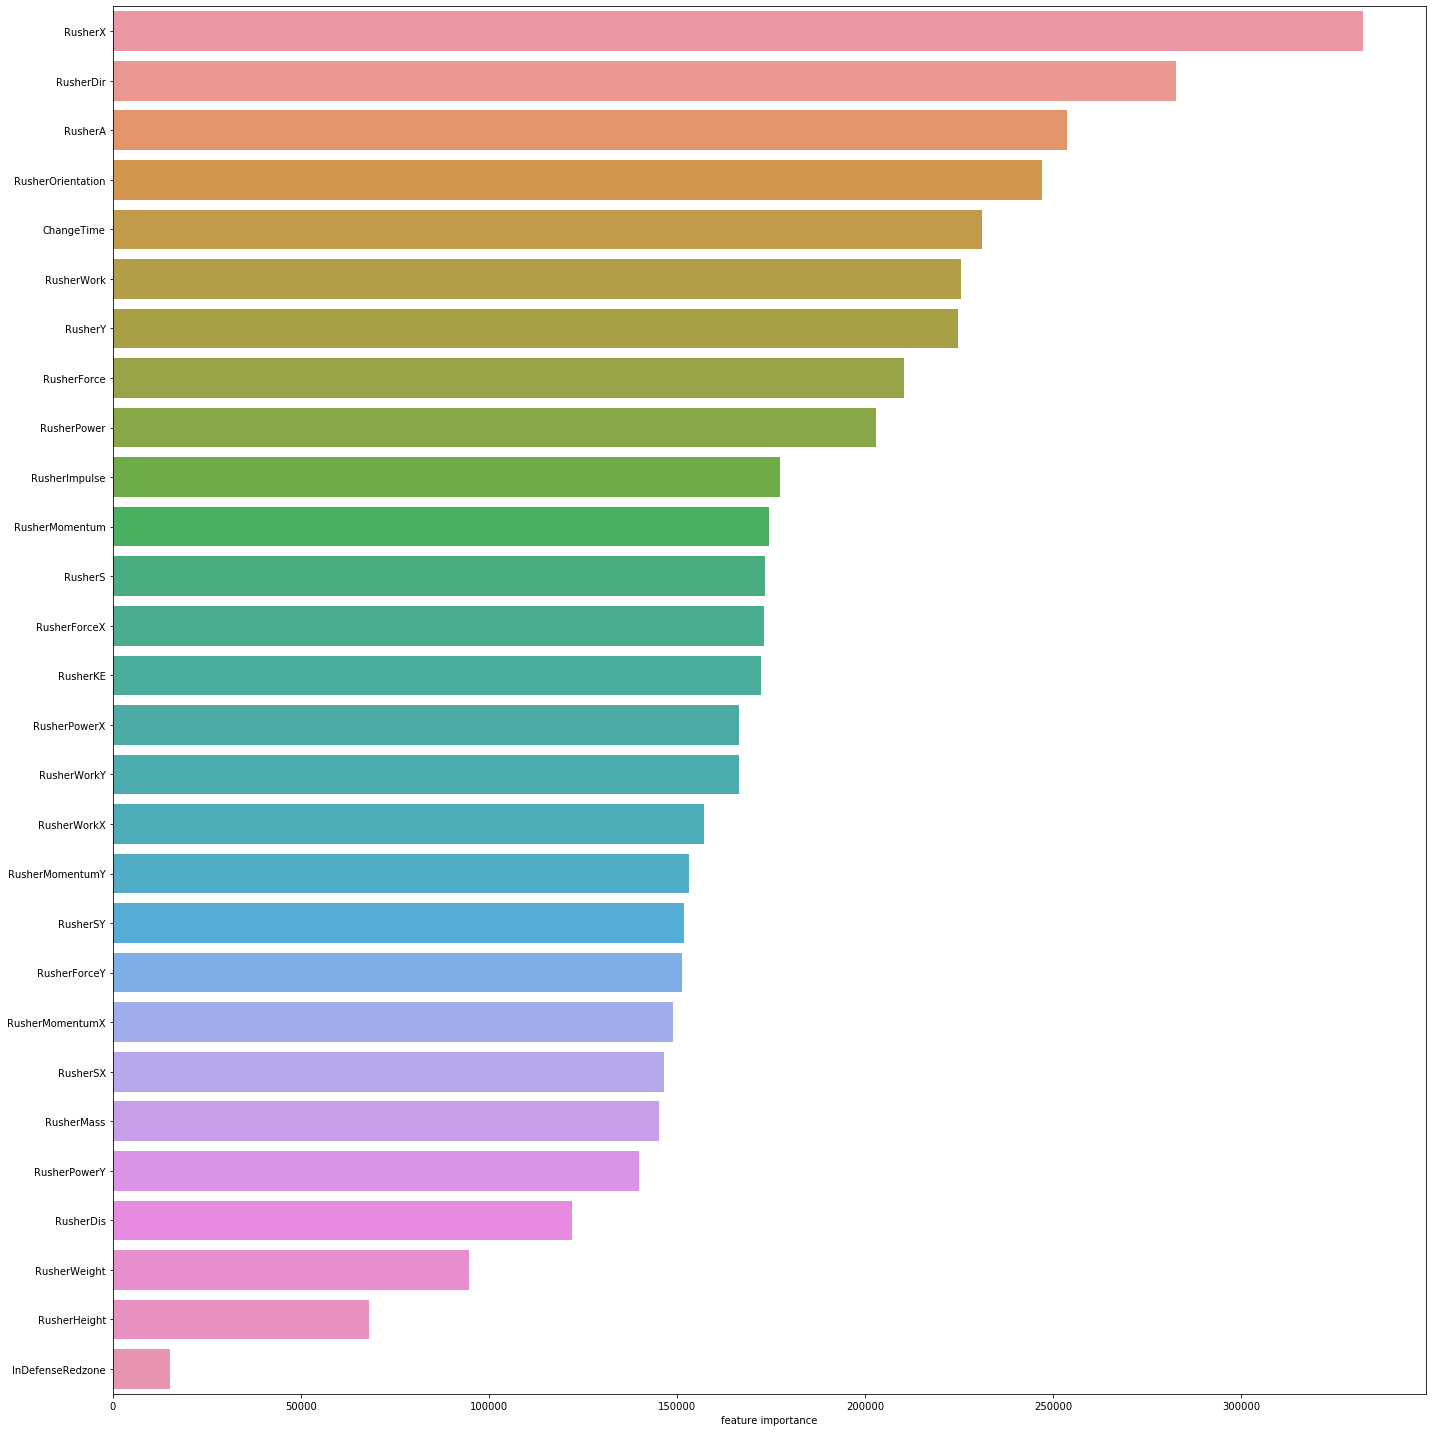

In [11]:
## Visualize feature importance

# make a LightGBM dataset
trainX, testX, trainY, testY = train_test_split(X_select, y_select, test_size=0.33, random_state=42)
d_train = lgb.Dataset(trainX, trainY)
d_eval = lgb.Dataset(testX, testY, reference=d_train)

# model training
LGBmodel = lgb.train(lgbParams, d_train, valid_sets=d_eval, verbose_eval=1000)
# LGBmodel = lgb.train(lgbParams, d_train, valid_sets=d_eval, early_stopping_rounds=500, verbose_eval=1000)

# feature importance
importance = LGBmodel.feature_importance(importance_type="gain")
ranking = np.argsort(-importance)
fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(x=importance[ranking], y=trainX.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()

In [12]:
features = trainX.columns.values[ranking][:15].tolist()
num = list(set(features) & set(num)) # update num to only show intersection with features selected
features = ['GameId','PlayId'] + features + cat
print(features)
X = X[features]
# Edit later to only include cat intersections too. This will require changing
# the way the NN works

['GameId', 'PlayId', 'RusherX', 'RusherDir', 'RusherA', 'RusherOrientation', 'ChangeTime', 'RusherWork', 'RusherY', 'RusherForce', 'RusherPower', 'RusherImpulse', 'RusherMomentum', 'RusherS', 'RusherForceX', 'RusherKE', 'RusherPowerX', 'InDefenseRedzone']


In [13]:
scaler = StandardScaler()
X[num] = scaler.fit_transform(X[num])

In [14]:
def model_396_1():
    inputs = []
    embeddings = []
    for i in cat:
        input_ = Input(shape=(1,))
        embedding = Embedding(int(np.absolute(X[i]).max() + 1), 10, input_length=1)(input_)
        embedding = Reshape(target_shape=(10,))(embedding)
        inputs.append(input_)
        embeddings.append(embedding)
    input_numeric = Input(shape=(len(num),))
    embedding_numeric = Dense(512, activation='relu')(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    x = Concatenate()(embeddings)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(199, activation='softmax')(x)
    model = Model(inputs, output)
    return model


n_splits = 2
kf = GroupKFold(n_splits=n_splits)
score = []
for i_369, (tdx, vdx) in enumerate(kf.split(X, y, X['GameId'])):
    print(f'Fold : {i_369}')
    X_train, X_val, y_train, y_val = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    X_train = [np.absolute(X_train[i]) for i in cat] + [X_train[num]]
    X_val = [np.absolute(X_val[i]) for i in cat] + [X_val[num]]
    model = model_396_1()
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[])
    es = EarlyStopping(monitor='val_CRPS', 
                   mode='min',
                   restore_best_weights=True, 
                   verbose=2, 
                   patience=5)
    es.set_model(model)
    metric = Metric(model, [es], [(X_train,y_train), (X_val,y_val)])
    for i in range(1):
        model.fit(X_train, y_train, verbose=False)
    for i in range(1):
        model.fit(X_train, y_train, batch_size=64, verbose=False)
    for i in range(1):
        model.fit(X_train, y_train, batch_size=128, verbose=False)
    for i in range(1):
        model.fit(X_train, y_train, batch_size=256, verbose=False)
    model.fit(X_train, y_train, callbacks=[metric], epochs=100, batch_size=1024, verbose=False)
    score_ = crps(y_val, model.predict(X_val))
    model.save(f'keras_369_{i_369}.h5')
    print(score_)
    score.append(score_)

Fold : 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

In [ ]:
print(np.mean(score))

In [ ]:
models = []
for i in range(n_splits):
    models.append(load_model(f'keras_369_{i}.h5'))

In [ ]:
for (test_df, sample_prediction_df) in tqdm.tqdm(iter_test):
    basetable = create_features(test_df)
    basetable = process_two(basetable)
    basetable = basetable[features]
    basetable[num] = scaler.transform(basetable[num])
    test_ = [np.absolute(basetable[i]) for i in cat] + [basetable[num]]
    
    y_pred = np.mean([model.predict(test_) for model in models], axis=0)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]
    
    preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
    env.predict(preds_df)
    
env.write_submission_file()